In [1]:
from aopy import datareader, datafilter
from ecog_is2s import EcogDataloader, Training
from ecog_is2s.model import Encoder, Decoder, Seq2Seq
from ecog_is2s.model import Util

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.sampler import SequentialSampler, BatchSampler, SubsetRandomSampler
from torch.utils.data import TensorDataset, random_split

import spacy
import numpy as np
import pandas as pd
# import sklearn
import scipy as sp

import random
import math
import time

import progressbar as pb
import datetime
import os

import matplotlib.pyplot as plt

import pickle as pkl

In [2]:
# seed RNG for pytorch/np
SEED = 5050
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
# load data
data_file_full_path = '/Volumes/Samsung_T5/aoLab/Data/WirelessData/Goose_Multiscale_M1/180325/001/rec001.LM1_ECOG_3.clfp.dat'
data_in, data_param, data_mask = datareader.load_ecog_clfp_data(data_file_name=data_file_full_path)
srate_in= data_param['srate']
num_ch = data_param['num_ch']
# we already found the appropriate data masks, so just load them in
mask_file_path = "/Volumes/Samsung_T5/aoLab/Data/WirelessData/Goose_Multiscale_M1/180325/001/rec001.LM1_ECOG_3.clfp.mask.pkl"
with open(mask_file_path, 'rb') as f:
    mask_data = pkl.load(f)
hf_mask = mask_data["hf"]
sat_mask = mask_data["sat"]

# mask data array, remove obvious outliers
data_in[:,np.logical_or(hf_mask,sat_mask)] = 0.

Loading data file:


In [4]:
# downsample the data
srate_down = 250
total_len_T = 20*60 # I just don't have that much time!
total_len_n = total_len_T*srate_in
data_idx = data_in.shape[1]//2 + np.arange(total_len_n)
print('Downsampling data from {0} to {1}'.format(srate_in,srate_down))
data_in = np.float32(sp.signal.decimate(data_in[:,data_idx],srate_in//srate_down,axis=-1))

Downsampling data from 1000 to 250


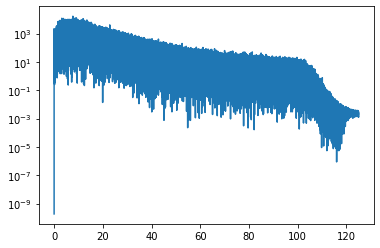

In [5]:
f,pxx = sp.signal.periodogram(data_in[np.random.randint(0,61),:],fs=srate_down)
plt.plot(f,pxx)
plt.yscale('log')

In [6]:
# create dataset object from file
srate = srate_down
# data_in = np.double(data_in[:,:120*srate])
enc_len = 100
dec_len = 10
seq_len = enc_len+dec_len # use ten time points to predict the next time point

data_tensor = torch.from_numpy(sp.stats.zscore(data_in.view().transpose()))
print(data_tensor.size)
dataset = EcogDataloader.EcogDataset(data_tensor,seq_len) ## make my own Dataset class


<built-in method size of Tensor object at 0x1a2bf99c30>


In [8]:
train_frac = 0.8
test_frac = 0.2
valid_frac = 0.0
BATCH_SIZE = 1

idx_all = np.arange(dataset.data.shape[0])
sample_idx = idx_all[:-seq_len]

train_loader, test_loader, valid_loader = EcogDataloader.genLoaders(dataset, sample_idx, train_frac, test_frac, valid_frac, BATCH_SIZE)

(239912,) (59977,) (0,)


In [9]:
# build the model, initialize
INPUT_SEQ_LEN = enc_len
OUTPUT_SEQ_LEN = dec_len # predict one output state from 10 inputs prior
INPUT_DIM = num_ch
OUTPUT_DIM = num_ch
HID_DIM = num_ch
N_ENC_LAYERS = 1 
N_DEC_LAYERS = 1
ENC_DROPOUT = np.float32(0.5)
DEC_DROPOUT = np.float32(0.5)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

enc = Encoder.Encoder_GRU(INPUT_DIM, HID_DIM, N_ENC_LAYERS, ENC_DROPOUT)
dec = Decoder.Decoder_GRU(OUTPUT_DIM, HID_DIM, N_DEC_LAYERS, DEC_DROPOUT)

model = Seq2Seq.Seq2Seq_GRU(enc, dec, device).to(device)
model.apply(Util.init_weights)

print(f'The model has {Util.count_parameters(model):,} trainable parameters')

optimizer = optim.Adam(model.parameters())
criterion = nn.MSELoss()

The model has 50,778 trainable parameters


/Users/mickey/anaconda3/envs/ecog_is2s/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [ ]:
N_EPOCHS = 50
CLIP = 1

best_test_loss = float('inf')

train_loss = np.zeros(N_EPOCHS)
train_batch_loss = []
test_loss = np.zeros(N_EPOCHS)
test_batch_loss = []


f = plt.figure()
ax = f.add_subplot(1,1,1)

for e_idx, epoch in enumerate(range(N_EPOCHS)):
    
    start_time = time.time()
    
    # get new train/test splits
    train_loader, test_loader, _ = EcogDataloader.genLoaders(dataset, sample_idx, train_frac, test_frac, valid_frac, BATCH_SIZE)
    
    print('Training Network:')
    train_loss[e_idx], trbl_ = Training.train(model, train_loader, optimizer, criterion, CLIP)
    train_batch_loss.append(trbl_)
    print('Testing Network:')
    test_loss[e_idx], tebl_ = Training.evaluate(model, test_loader, criterion)
    test_batch_loss.append(tebl_)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = Util.epoch_time(start_time, end_time)
    
    if test_loss[e_idx] < best_test_loss:
        best_test_loss = test_loss[e_idx]
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss[e_idx]:.3g}')
    print(f'\t Test Loss: {test_loss[e_idx]:.3g}')
    
    ax.plot(e_idx,train_loss[e_idx],'b.')
    ax.plot(e_idx,test_loss[e_idx],'r.')
    f.print('training_progress.png')

(239912,) (59977,) (0,)
Training Network:
999 239912
1999 239912
2999 239912
3999 239912
4999 239912
5999 239912
6999 239912
7999 239912
8999 239912
9999 239912
10999 239912
11999 239912
12999 239912
13999 239912
14999 239912
15999 239912
16999 239912
17999 239912
18999 239912
19999 239912
20999 239912
21999 239912
22999 239912
23999 239912
24999 239912
25999 239912
26999 239912
27999 239912
28999 239912
29999 239912
30999 239912
31999 239912
32999 239912
33999 239912
34999 239912
35999 239912
36999 239912
37999 239912
38999 239912
39999 239912
40999 239912
41999 239912
42999 239912
43999 239912
44999 239912
45999 239912
46999 239912
47999 239912
48999 239912
49999 239912
50999 239912
51999 239912
52999 239912
53999 239912
54999 239912
55999 239912
56999 239912
57999 239912
58999 239912
59999 239912
60999 239912
61999 239912
62999 239912
63999 239912
64999 239912
65999 239912
66999 239912
67999 239912
68999 239912
69999 239912
70999 239912
71999 239912
72999 239912
73999 239912
74999 2